In [1]:
import os
import datetime as dt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
sns.set_context('talk',font_scale=1)

In [2]:
### SETUP INITIAL FEATURES ###

# only fluctuators
# [1016, 1018, 1019, 1023, 1024, 1029, 1030, 1032, 1038, 1039, 1043, 1044, 1046, 1049, 1051]

fluctuators = [142592, 142580, 142581, 142618, 142594, 142582, 142595, 142583, 142577, 142622, 142612, 142575, 142585, 142578, 142584]

# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features/')
Data  =pd.DataFrame()
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
for file in home_feature_files:
    user = int(file[9:15])
    if user not in fluctuators:
        continue
    date = dt.datetime.strptime(file[16:26], "%Y-%m-%d")
    
    # get MDS and Baseline MDS scores
    MDS_score = float('nan')
    baseline_mds = float('Nan')
    try:
        MDS_score = summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score']
        if(len(MDS_score.index.values) > 1):
            MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info.trial == 2) & (summary_info["6_digit_id"] == user), 'MDS_score'])
        else:
            MDS_score = int(MDS_score)
    except:
        MDS_score = float('Nan')
    try:
        baseline_mds = summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["6_digit_id"] == user), 'MDS_score']
        if(len(baseline_mds.index.values) > 1):
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info.trial == 2) & (summary_info["6_digit_id"] == user), 'MDS_score'])
        else:
            baseline_mds = int(baseline_mds)
    except:
        baseline_mds = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features//' + file)
    Xtest.insert(loc = 2, column = 'MDS score', value = [MDS_score for elem in Xtest.index.values])
    Xtest.insert(loc = 3, column = 'baseline MDS', value = [baseline_mds for elem in Xtest.index.values])
    Xtest.insert(loc = 0, column = 'Visit', value = date)
    Xtest = Xtest.drop('timestamp', axis = 1)
    Data = Data.append(Xtest, ignore_index = True)
Data = Data.dropna()
Data = Data.sort_values('Visit', kind = 'mergesort')
Data = Data.sort_values('Subject', kind = 'mergesort')
Data.head()
Xtrain = Data
Xtrain = Xtrain.reset_index(drop= True)

# use leave one subject out method to train models
features = pd.DataFrame()
for s in Xtrain['Subject'].unique():
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        mds = vtrain['MDS score'].mean()
        bmds = vtrain['baseline MDS'].mean()
        vtrain = vtrain.iloc[:, 4:]
        columns = vtrain.columns.values.tolist()
        # use bootstrapping to make 70 datapoints per subject-visit
        for i in range(200):
            cols = ['Subject', 'Visit', 'MDS score', 'baseline MDS']
            vals = [s,v, mds, bmds]
            # choose a bootstrapped sample composed of 1% of the original data
            sample = vtrain.sample(frac = 0.005, replace = False)
            for c in columns:
                cols.append(c + " mean")
                cols.append(c + " var")
                vals.append(sample[c].mean())
                vals.append(sample[c].var())
            # add new features to features dataframe
            df = pd.DataFrame(data = [vals], columns = cols)
            features = features.append(df, ignore_index = True)
features = features.dropna()
features

,Subject,Visit,MDS score,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var,jerk_skew mean,jerk_skew var,jerk_kur mean,jerk_kur var
0,142575,2017-08-16,24.0,32.0,0.002495,0.000022,0.002790,0.000022,0.002367,0.000015,...,14.110737,78.255692,6.537765e-05,4.679301e-07,0.026718,0.002036,0.154421,0.648351,7.979385,208.680649
1,142575,2017-08-16,24.0,32.0,0.003170,0.000029,0.003909,0.000041,0.003188,0.000026,...,16.270224,91.299652,7.414097e-05,6.924326e-07,0.038083,0.005217,0.056437,0.832855,7.872257,158.968628
2,142575,2017-08-16,24.0,32.0,0.003482,0.000030,0.003805,0.000033,0.003112,0.000017,...,13.384167,89.301537,2.183631e-05,4.589093e-07,0.034746,0.002392,0.054988,0.716236,7.845726,124.249535
3,142575,2017-08-16,24.0,32.0,0.003205,0.000025,0.003866,0.000030,0.003118,0.000020,...,14.693747,97.203522,1.052844e-05,2.037352e-07,0.033654,0.002478,0.018009,0.363445,6.012640,70.943199
4,142575,2017-08-16,24.0,32.0,0.003007,0.000026,0.003495,0.000029,0.002795,0.000016,...,13.895985,102.475342,-1.007404e-05,1.226912e-07,0.033117,0.002482,0.101755,0.849231,8.435310,209.320847
5,142575,2017-08-16,24.0,32.0,0.002854,0.000022,0.003111,0.000024,0.002860,0.000021,...,15.254878,105.447136,-5.962694e-05,3.967704e-07,0.029665,0.001934,0.123593,1.700281,7.786629,372.000732
6,142575,2017-08-16,24.0,32.0,0.003556,0.000037,0.003603,0.000025,0.003120,0.000020,...,13.231422,87.980553,3.995471e-05,2.318530e-07,0.036022,0.002437,0.086003,0.978572,8.264675,211.710007
7,142575,2017-08-16,24.0,32.0,0.002760,0.000020,0.003442,0.000030,0.002724,0.000016,...,15.162702,99.208664,1.007400e-04,9.987203e-07,0.029917,0.001894,-0.086107,1.102488,9.635283,261.359528
8,142575,2017-08-16,24.0,32.0,0.002354,0.000016,0.003021,0.000025,0.002515,0.000016,...,13.256517,86.051941,8.464681e-05,3.898468e-07,0.028758,0.002356,0.119120,1.173259,9.242598,242.533920
9,142575,2017-08-16,24.0,32.0,0.002865,0.000021,0.003282,0.000022,0.002628,0.000014,...,14.457850,100.765640,1.164849e-05,2.961966e-07,0.030894,0.002134,0.211136,0.939728,8.149014,195.283707


In [3]:
### CALCULATE FIRST STACK ###

# setup
a = []; b = []; v = []; subjs = []
pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []

# use leave one subject out method to train models
for s in features['Subject'].unique():

    # setup regressors
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # split the training and test data
    Xtrain = features[(features['Subject'] != s)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # scale the training data
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train the regressors
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    # set up test data
    Xtest = features[(features['Subject'] == s)]
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and store in stacked_predictions dataframe
    if (len(Xtest) != 0):
        # scale the test data
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
# create new feature dataframe
stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred KNR
subj,1.000000,-0.064628,0.056598,-0.065775,-0.139198,-0.024307,-0.081299
actual mds,-0.064628,1.000000,0.560685,0.203596,0.246450,0.211317,0.113330
baseline mds,0.056598,0.560685,1.000000,0.192248,0.200271,0.081537,0.094706
pred RFR,-0.065775,0.203596,0.192248,1.000000,0.661599,0.621921,0.677433
pred NN,-0.139198,0.246450,0.200271,0.661599,1.000000,0.690412,0.544133
pred LN,-0.024307,0.211317,0.081537,0.621921,0.690412,1.000000,0.475311
pred KNR,-0.081299,0.113330,0.094706,0.677433,0.544133,0.475311,1.000000


In [4]:
### CALCULATE FINAL PREDICTIONS FROM FIRST STACK ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out method to train models
for s in stacked_predictions['subj'].unique():
    
    # split train and test data
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    # scale train and test data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
# build new predictions dataframe
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.064628,-0.327345,0.046947,0.034608,0.034608,-0.047824
actual mds,-0.064628,1.000000,0.463229,0.481552,0.431270,0.431270,0.458393
pred RFR,-0.327345,0.463229,1.000000,0.648599,0.428558,0.428558,0.538455
pred NN,0.046947,0.481552,0.648599,1.000000,0.436169,0.436169,0.803381
pred LN,0.034608,0.431270,0.428558,0.436169,1.000000,1.000000,0.383641
pred LARS,0.034608,0.431270,0.428558,0.436169,1.000000,1.000000,0.383641
pred KNR,-0.047824,0.458393,0.538455,0.803381,0.383641,0.383641,1.000000


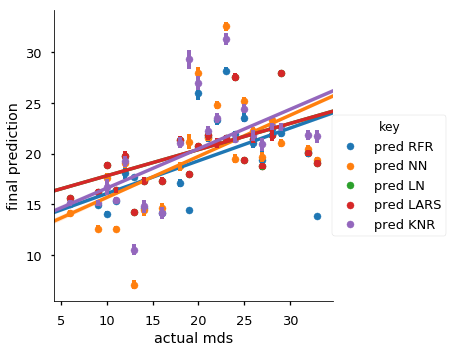

In [5]:
### DISPLAY PREDICTIONS ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[2:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.5606847594982586
RMSE: 6.071281999403345
Cohen Kappa Score: 0.05147058823529416


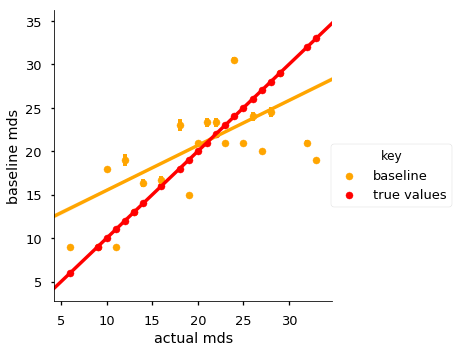

In [14]:
### 1 stack followed by baseline ###
dis = pd.DataFrame()
dis['baseline mds'] = stacked_predictions['baseline mds']
dis['actual mds'] = stacked_predictions['actual mds']
dis['key'] = 'baseline'
act = pd.DataFrame()
act['baseline mds'] = stacked_predictions['actual mds']
act['actual mds'] = stacked_predictions['actual mds']
act['key'] = 'true values'
print('correlation coefficient: ' + np.corrcoef(dis['baseline mds'], dis['actual mds'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(dis['baseline mds']) - dis['actual mds'])**2))).__str__()) 
print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in dis['baseline mds'].values], [int(p) for p in dis['actual mds']]).__str__()) 
dis = dis.append(act)
colors = {'baseline': 'orange', 'true values': 'r'}
sns.lmplot(x = 'actual mds', y = 'baseline mds', hue = 'key', data = dis, order = 1, x_estimator= np.mean, palette = colors)

correlation coefficient: 0.46322908816666475
RMSE: 6.170271646049832


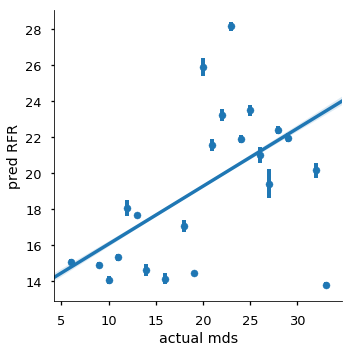

In [7]:
### 1 stack followed by RFR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred RFR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred RFR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.4815521611381085
RMSE: 6.332476226211118


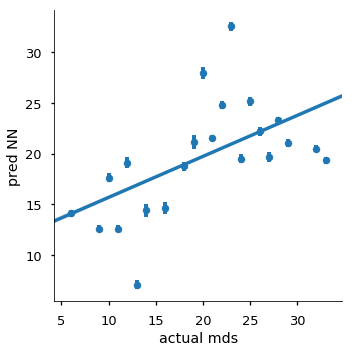

In [8]:
### 1 stack followed by NN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred NN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred NN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.43127043801874243
RMSE: 6.138527660142348


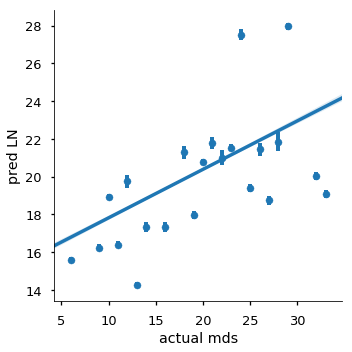

In [9]:
### 1 stack followed by LN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.431270438018742
RMSE: 6.138527660142352


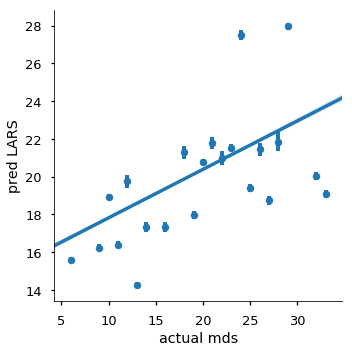

In [10]:
### 1 stack followed by LARS ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LARS'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LARS'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.45839295293701915
RMSE: 6.4890717203863195


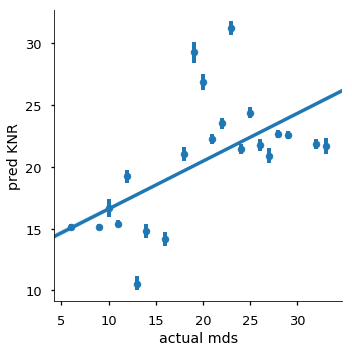

In [11]:
### 1 stack followed by KNR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred KNR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred KNR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [12]:
### CALCULATE THE SECOND STACK FROM THE FIRST STACK - WITHOUT BASELINE ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use leave one subject out method to train models
for s in stacked_predictions['subj'].unique():
    
    # split test and train groups
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale test and train data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
# build second feature matrix
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.064628,0.056598,-0.080705,-0.127193,-0.063777,-0.063777,-0.080284
actual mds,-0.064628,1.000000,0.560685,0.040599,0.007055,-0.049926,-0.049926,0.025731
baseline mds,0.056598,0.560685,1.000000,-0.018146,-0.011965,-0.065046,-0.065046,-0.018994
pred RFR,-0.080705,0.040599,-0.018146,1.000000,0.741393,0.532299,0.532299,0.816619
pred NN,-0.127193,0.007055,-0.011965,0.741393,1.000000,0.628031,0.628031,0.687760
pred LN,-0.063777,-0.049926,-0.065046,0.532299,0.628031,1.000000,1.000000,0.495907
pred LARS,-0.063777,-0.049926,-0.065046,0.532299,0.628031,1.000000,1.000000,0.495907
pred KNR,-0.080284,0.025731,-0.018994,0.816619,0.687760,0.495907,0.495907,1.000000


,subj,actual mds,final prediction
subj,1.000000,-0.064628,0.176258
actual mds,-0.064628,1.000000,0.535776
final prediction,0.176258,0.535776,1.000000


num data points: 8600
correlation coefficient: 0.5357756011518406
RMSE: 5.783110509026129
Cohen Kappa Score: 0.007498848613108455


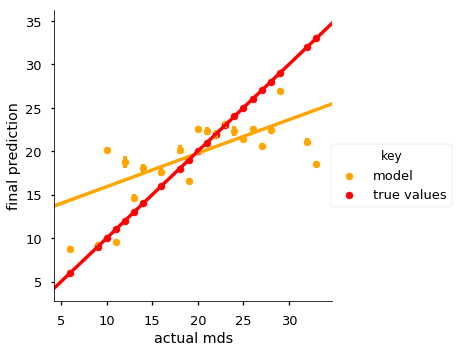

In [13]:
### CALCULATE FINAL PREDICTIONS FROM SECOND STACK ###

# build regressors
#clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
#        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]
clfs = [MLPRegressor(max_iter = 10000, random_state = 2)]

# display the results using each regressor
for clf_final in clfs:
    
    # setup needed variables
    actual_mds = []; predictions_final = []; subjs3 = []
    
    # use leave one subject out method to train regressor
    for s in second_stack_predictions['subj'].unique():

        # split test train data
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
        
        # scale data
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
        
        # train regressor
        clf_final.fit(second_stack_train, second_stack_ytrain)
        
        # make predictions and store in predictions dataframe
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test))
            subjs3 += [s for elem in list(second_stack_ytest)]
    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    # display results
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'
    
    print("num data points: " + len(predictions.index.values).__str__())
    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in predictions['final prediction'].values], [int(p) for p in predictions['actual mds']]).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    colors = {'model': 'orange', 'true values': 'r'}
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator= np.mean, palette = colors)
    plt.show()